- 스트리밍 복제가 여러 대기 서버에서 작동하는 방식을 설명

# **sync_priority and sync_state**

- 기본 서버는 모든 관리되는 대기 서버에 sync_priority 및 sync_state 속성을 할당하고 각 대기 서버를 해당 값에 따라 처리. (기본 서버는 대기 서버를 하나만 관리하더라도 이러한 값을 할당)

- sync_priority 속성 은 동기 모드에서 대기 서버의 우선 순위를 나타냄.
  - 값이 낮을수록 우선순위가 높아짐.
  - 특수값 0은 대기 서버가 ' 비동기 모드 '에 있음을 의미.
  - 대기 서버의 우선순위는 기본 서버의 구성 매개변수 synchronous_standby_names 에 나열된 순서대로 할당됨.
  - 예를 들어 다음 구성에서 Standby1과 Standby2의 우선순위는 각각 1과 2.

- synchronous_standby_names = 'standby1, standby2'
(이 매개변수에 나열되지 않은 대기 서버는 비동기 모드이며 우선순위는 0)

- sync_state는 대기 서버의 상태. sync_state 속성 은 대기 서버의 상태를 나타냄. 다음 값 중 하나일 수 있음.
  - sync: 대기 서버는 동기 모드에 있으며 현재 작동 중인 대기 서버 중 우선순위가 가장 높음.
  - potential: 대기 서버는 동기 모드에 있으며 현재 작동 중인 우선 순위가 낮은 대기 서버.
    - 현재 동기화 대기 서버가 실패하면 이 대기 서버는 동기화 상태로 승격됨.
  - async: 대기 서버가 비동기 모드. (절대로 '동기화' 또는 '잠재적' 모드가 아님.)

- 대기 서버의 우선순위와 상태는 다음 쿼리를 실행하여 표시할 수 있음.



```
testdb=# SELECT application_name AS host,
         sync_priority, sync_state FROM pg_stat_replication;
   host   | sync_priority | sync_state
----------+---------------+------------
 standby1 |             1 | sync
 standby2 |             2 | potential
(2 rows)
```

# **How the Primary Manages Multiple-standbys**

- 기본 서버는 동기 대기 서버의 ACK 응답을 단독으로 기다림.
  - 즉, 기본 서버는 동기 대기 서버의 WAL 데이터 쓰기 및 플러시만 확인.
  - 따라서 스트리밍 복제는 동기식 대기만 기본과 일관되고 동기적인 상태에 있도록 보장.

- 그림은 잠재적 대기의 ACK 응답이 기본 대기의 ACK 응답보다 먼저 반환된 경우를 보여줌.
  -  이 경우 기본 서버는 현재 트랜잭션의 커밋 작업을 완료하지 않고 계속해서 기본 서버의 ACK 응답을 기다림.
  - 기본 응답이 수신되면 백엔드 프로세스는 래치를 해제하고 현재 트랜잭션 처리를 완료.

**Managing multiple standby servers.**

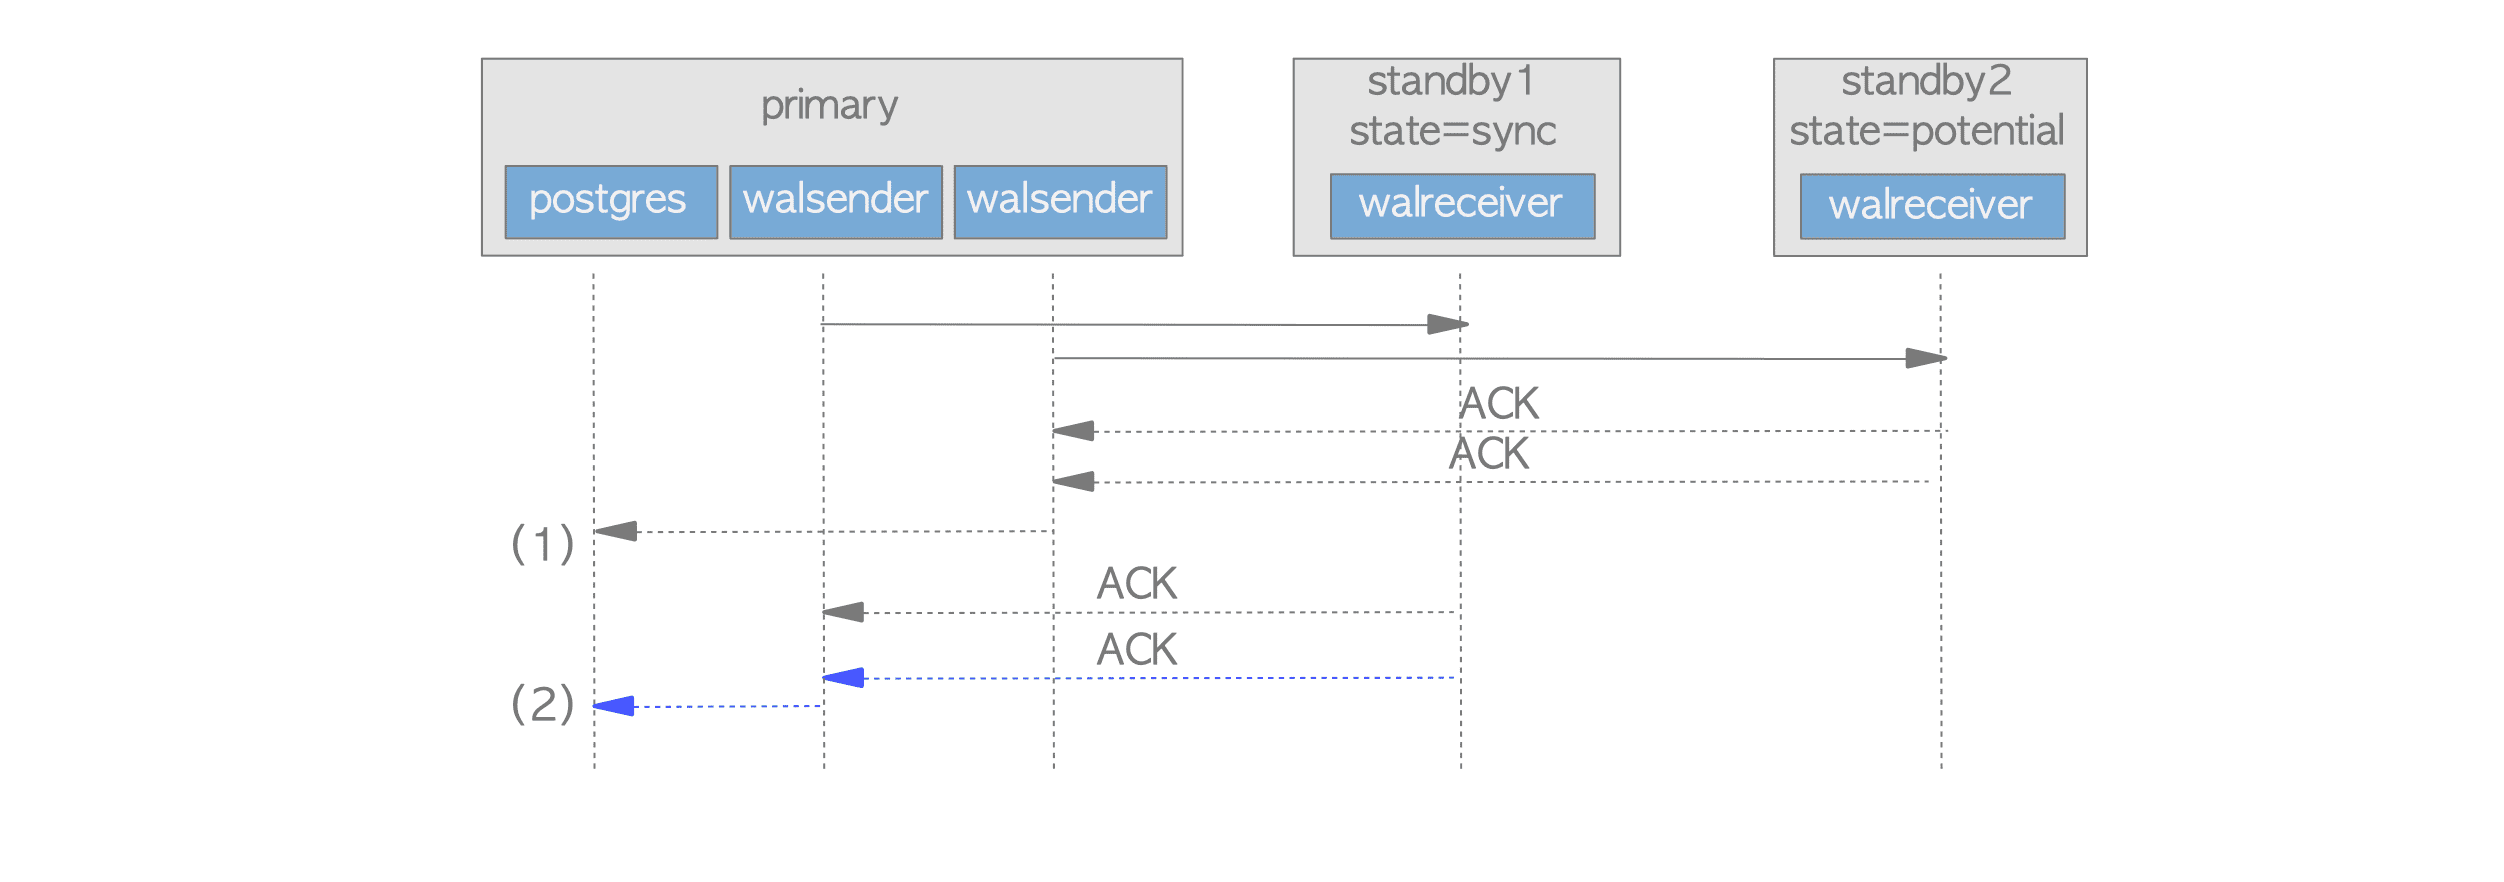

- Standby1과 Standby2의 sync_state는 각각 'sync' 와 'potential'
1. 기본 백엔드 프로세스는 잠재적 대기 서버로부터 ACK 응답을 받았음에도 불구하고 동기 대기 서버로부터 ACK 응답을 계속 기다림.
2. 동기식 대기 서버로부터 ACK 응답을 받은 후 기본 백엔드 프로세스는 래치를 해제하고 현재 트랜잭션 처리를 완료.

- 반대의 경우(즉, 기본의 ACK 응답이 잠재적인 것보다 먼저 반환된 경우) 기본 서버는 잠재적인 대기가 WAL 데이터를 쓰고 플러시하는지 여부를 확인하지 않고 현재 트랜잭션의 커밋 작업을 즉시 완료

# **Behavior When a Failure Occurs**

- 다시 한 번 대기 서버에 장애가 발생했을 때 기본 서버가 어떻게 동작하는지 확인

- 잠재적 또는 비동기 대기 서버가 실패하면 기본 서버는 실패한 대기에 연결된 walsender 프로세스를 종료하고 모든 처리를 계속
  - 즉, 기본 서버의 트랜잭션 처리는 두 유형의 대기 서버 모두에 장애가 발생하더라도 영향을 받지 않음.

- 동기 대기 서버가 실패하면 기본 서버는 실패한 대기에 연결된 walsender 프로세스를 종료하고 동기 대기를 우선 순위가 가장 높은 잠재적 대기로 교체.
  - 위에서 설명한 장애와 달리, 장애 발생 시점부터 동기 대기 서버 교체 전까지 기본 서버의 쿼리 처리가 일시 중지됨. (따라서 대기 서버의 장애 감지는 복제 시스템의 가용성을 높이는 데 매우 중요한 기능.)

**Replacing of synchronous standby server.**

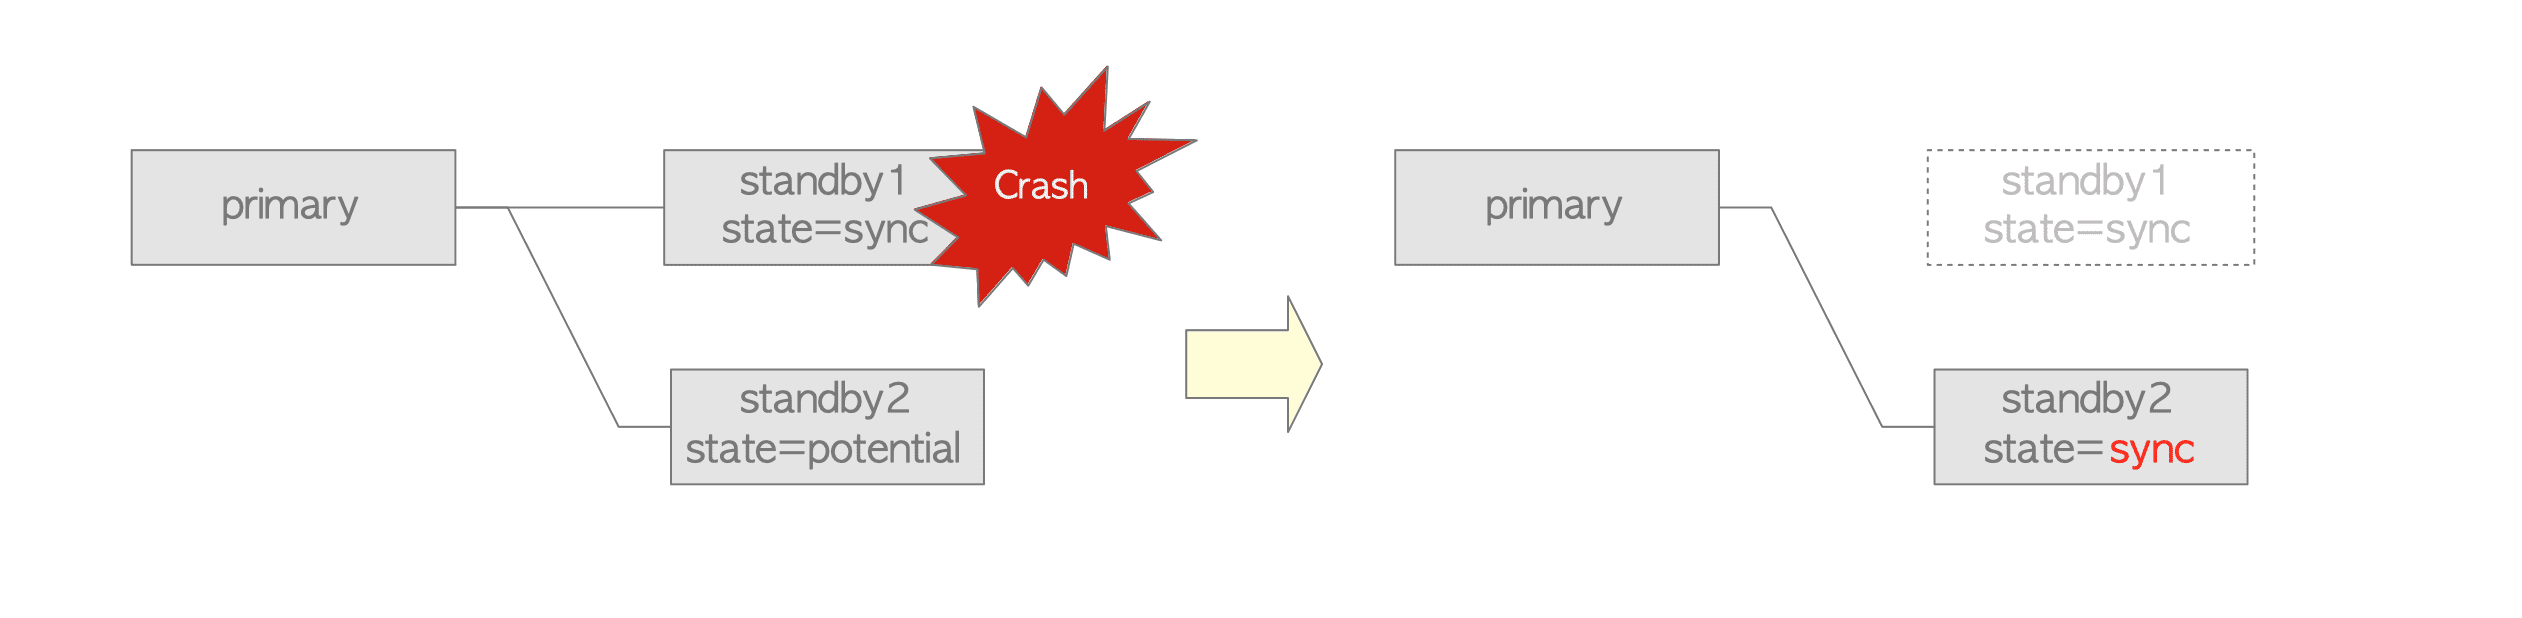

- 어떤 경우든 하나 이상의 대기 서버가 동기 모드로 실행 중인 경우 기본 서버는 항상 하나의 동기 대기 서버만 유지하며 동기 대기 서버는 항상 기본 서버와 일관되고 동기적인 상태를 유지